In [36]:
import numpy as np
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
import pandas as pd
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [37]:
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

In [38]:
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [39]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

In [40]:
# transform series into train and test sets for supervised learning
# تابع آماده‌سازی داده‌ها
def prepare_data(series, n_test, n_lag, n_seq):
    # استخراج مقدار خام
    raw_values = series.values

    # بررسی اینکه تابع `difference()` تعریف شده باشد
    def difference(dataset, interval=1):
        return pd.Series([dataset[i] - dataset[i - interval] for i in range(interval, len(dataset))])

    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values.reshape(len(diff_series), 1)

    # مقیاس‌گذاری داده‌ها
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)

    # تبدیل به داده‌های نظارتی
    def series_to_supervised(data, lag, seq):
        X, y = [], []
        for i in range(len(data) - lag - seq + 1):
            X.append(data[i:i+lag])
            y.append(data[i+lag:i+lag+seq])
        return pd.DataFrame(np.hstack((X, y)))

    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values

    # تقسیم داده‌ها به آموزش و تست
    train, test = supervised_values[:-n_test], supervised_values[-n_test:]
    return scaler, train, test

In [41]:
# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # تبدیل داده‌های ورودی
    X, y = train[:, :n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])  # تغییر شکل مناسب برای LSTM

    # طراحی مدل
    model = Sequential()
    model.add(LSTM(n_neurons, input_shape=(X.shape[1], X.shape[2]), stateful=False))  # حذف `stateful=True`
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # آموزش مدل
    model.fit(X, y, epochs=nb_epoch, batch_size=n_batch, verbose=1, shuffle=True)

    return model

In [42]:
# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
	# reshape input pattern to [samples, timesteps, features]
	X = X.reshape(1, 1, len(X))
	# make forecast
	forecast = model.predict(X, batch_size=n_batch)
	# convert to array
	return [x for x in forecast[0, :]]

In [43]:
# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = forecast_lstm(model, X, n_batch)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

In [44]:
# invert differenced forecast
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted

In [45]:
# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
	inverted = list()
	for i in range(len(forecasts)):
		# create array from forecast
		forecast = array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		# invert scaling
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]
		# invert differencing
		index = len(series) - n_test + i - 1
		last_ob = series.values[index]
		inv_diff = inverse_difference(last_ob, inv_scale)
		# store
		inverted.append(inv_diff)
	return inverted

In [46]:
# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))

In [47]:
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	pyplot.show()

In [48]:
# load dataset
series = pd.read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, date_parser=parser)

C:\Users\pouya\AppData\Local\Temp\ipykernel_10504\2752032603.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  series = pd.read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, date_parser=parser)


In [49]:
# configure
n_lag = 1
n_seq = 3
n_test = 10
n_epochs = 1500
n_batch = 1
n_neurons = 1

In [51]:
# fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

Epoch 1/1500


c:\Users\pouya\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1630
Epoch 2/1500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1309 
Epoch 3/1500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1028 
Epoch 4/1500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1176 
Epoch 5/1500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1166 
Epoch 6/1500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1095 
Epoch 7/1500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1412 
Epoch 8/1500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1405 
Epoch 9/1500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1396 
Epoch 10/1500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1421 
Epoch 11/1500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1017 
Epoch 12/1500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1469 
Epoch 13/1500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1404 
Epoch 14/1500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1038 
Epoch 15/1500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

In [52]:
# make forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [53]:
# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)

In [54]:
# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)

t+1 RMSE: 94.621458
t+2 RMSE: 78.318455
t+3 RMSE: 110.862502


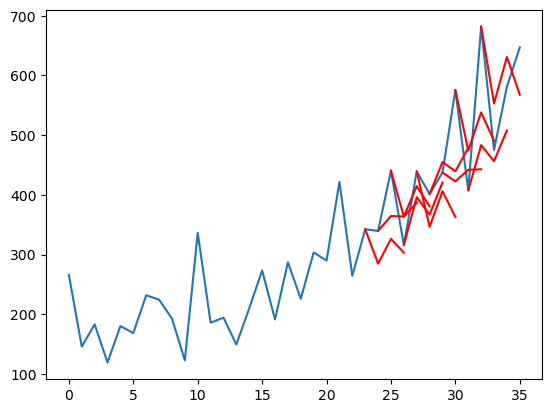

In [55]:
# plot forecasts
plot_forecasts(series, forecasts, n_test+2)